In [ ]:
#for each pft/region 

# process data into df 

#for sos 

    #take mean of region's SOS dates 

    #take 30 day period with highest attention score 

    #get relative feature importance 





In [1]:
import pandas as pd
import numpy as np
from itertools import product
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec


def get_analysis_df(data, preds, coord_path):
    """ Match original data to predictions and corresponding coordinates.

    Parameters
    ----------
    data_path : str
        path to original processed data dictionnary 
    pred_path : str
        path to predictions dictionnary
    coord_path : str
        path to dataframe matching location index to coordinates

    Returns
    -------
    pd.Dataframe
        dataframe with groundtruth values, predictions and corresponding time and coordinates

    """
    
    coords=pd.read_parquet(coord_path)
    coords= coords.drop_duplicates()

    # get location ID and grountruth CSIF from original data
    df = pd.DataFrame({
        'Index': data['data_sets']['test']['id'].flatten(),
        'Flattened_Values': data['data_sets']['test']['target'].flatten(),})
    #retrive future drivers map from predictions
    df['pred_05'] = preds['predicted_quantiles'][:, :, 1].flatten()
    df[['location_id', 'time_id']] = df['Index'].str.split('_', n=1, expand=True)
    df['location_id'] = df['location_id'].astype(int)
    df['time_id'] = pd.to_datetime(df['time_id'])
    df = df.sort_values(by=['location_id','time_id'])
    df['doy']=df['time_id'].dt.dayofyear
    df['year']= df['time_id'].dt.year
    df['month']= df['time_id'].dt.month
    df['day']= df['time_id'].dt.day
    df = df.rename(columns={'Flattened_Values': 'CSIF', 'location_id': 'location', 'time_id': 'time'})
    df = df.drop(columns=['Index'])
    df = pd.merge(coords, df, on='location', how='left')



    return df


def spring_series_indices(df, month_start, month_end, specific_year=None):
    """
        output: indexes of time series predicted in the spring time.
    """
    res_indices=[]
    for year in range(2002, 2011):
        if specific_year is not None:
            year= specific_year
            
        dt_start = datetime(year, month_start, 10)
        dt_end = datetime(year, month_end, 30)
        df_current_year=df[df['year']==year]
        filtered_df =df_current_year.groupby('location').filter(lambda x: (x['time'].iloc[0] >= dt_start ) and (x['time'].iloc[0] <= dt_end))
        indices_array = np.unique(filtered_df[::30].index.to_numpy())
        print('indeces_array', indices_array)
        res_indices.extend(np.round(indices_array/30).astype(int))
        if specific_year is not None:
            break

        return res_indices

        
    # TO DO : case for EOS 

def plot_attention(data_path,pred_path,coord_path, month_start, month_end, lat_min, lat_max ):

    with open(data_path,'rb') as fp:
        data = pickle.load(fp)
    with open(pred_path,'rb') as fp_2:
        preds = pickle.load(fp_2)

    df = get_analysis_df(data, preds, coord_path)
    fp.close()
    
    df=df[df['latitude']<lat_max]
    df=df[df['latitude']>lat_min]
    
    select_indices = spring_series_indices(df, month_start, month_end)
    
    att_mat_list=[]
    csif_ts=[]

    for index in select_indices:
        att_mat_list.append(preds['attention_scores'][index])
        csif_ts.append(np.concatenate([np.array(data['data_sets']['test']['historical_ts_numeric'][index][:,0]),np.array(data['data_sets']['test']['target'][index])], axis=0))

    stacked_att= np.stack(att_mat_list, axis=0)
    att_mean_array= np.mean(stacked_att, axis=0)

    stacked_csif_ts = np.stack(csif_ts, axis=0)
    csif_mean_array = np.mean(stacked_csif_ts, axis=0)

    plt.plot(csif_mean_array)
    fp_2.close()
    
    plt.figure(figsize=(20, 3))
    cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])
    sns.heatmap(att_mean_array, cmap=cmap0)  # You can choose different colormaps like 'coolwarm', 'Blues', etc.
    plt.axvline(x=365, color='black', linestyle='--', linewidth=1)
    # Adding titles and labels as needed
    plt.xlabel('Time')
    plt.ylabel('Horizon')
    plt.title(data_path.split('/')[-1].split('.')[0] + season)

indeces_array [    750    1740    2730 ... 4445310 4446300 4447290]


/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:15

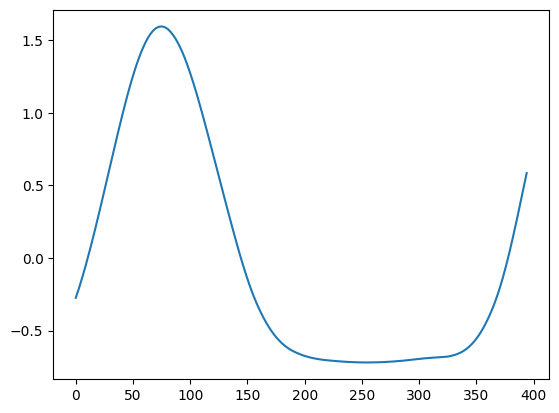

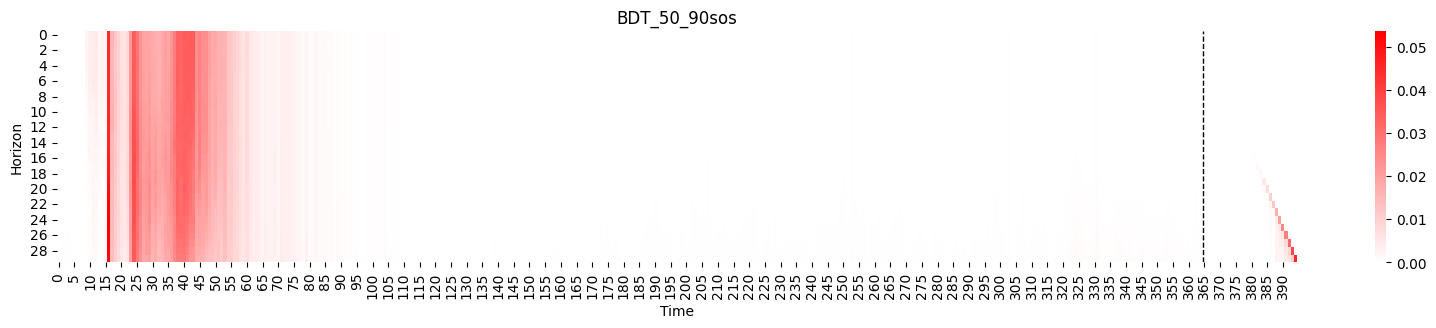

In [4]:
PFT='BDT_50_90'
season = 'sos'
lat_min = 50
lat_max = 90
month_start = 4
month_end = 5
data_path = '/burg/glab/users/al4385/data/TFT_30/'+PFT+'.pickle'
pred_path = '/burg/glab/users/al4385/predictions/TFT_30_0429/pred_'+PFT+'.pkl'
coord_path ='/burg/glab/users/al4385/data/coordinates/'+PFT+'.parquet'
plot_attention(data_path,pred_path,coord_path, month_start, month_end, lat_min, lat_max)

indeces_array [  87090   88080   89070  101220  102210  103200  115320  116310  117300
  129420  130410  131400  143520  144510  145500  157620  158610  159600
  171720  172710  173700  184830  185820  186810  198960  199950  200940
  213060  214050  215040  227160  228150  229140  241260  242250  243240
  255360  256350  257340  269460  270450  271440  282570  283560  284550
  296700  297690  298680  310800  311790  312780  324900  325890  326880
  339000  339990  340980  353100  354090  355080  367200  368190  369180
  380310  381300  382290  394440  395430  396420  408540  409530  410520
  422640  423630  424620  436740  437730  438720  450840  451830  452820
  464940  465930  466920  478050  479040  480030  492180  493170  494160
  506280  507270  508260  520380  521370  522360  534480  535470  536460
  548580  549570  550560  562680  563670  564660  575790  576780  577770
  589920  590910  591900  604020  605010  606000  618120  619110  620100
  632220  633210  634200  646320  647

/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/burg/opt/anaconda3-2023.09/lib/python3.11/site-packages/IPython/core/pylabtools.py:15

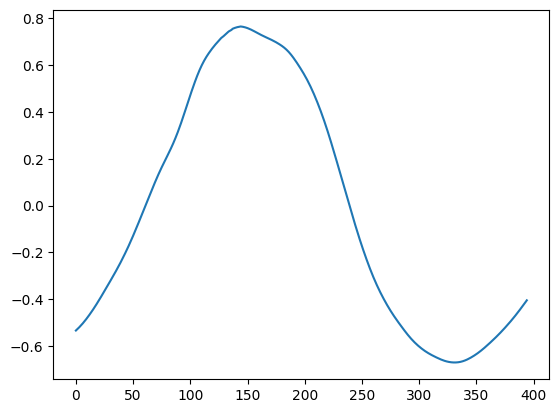

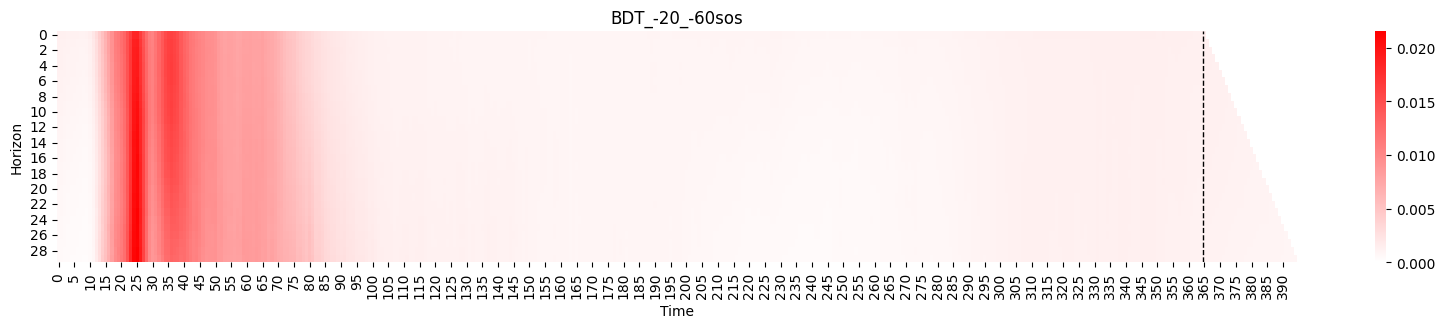

In [7]:
PFT='BDT_-20_-60'
season = 'sos'
lat_min = -60
lat_max = -20
month_start = 8
month_end = 8
data_path = '/burg/glab/users/al4385/data/TFT_30/'+PFT+'.pickle'
pred_path = '/burg/glab/users/al4385/predictions/TFT_30_0429/pred_'+PFT+'.pkl'
coord_path ='/burg/glab/users/al4385/data/coordinates/'+PFT+'.parquet'
plot_attention(data_path,pred_path,coord_path, month_start, month_end, lat_min, lat_max)

In [ ]:
PFT='BDT_-20_-60'
season = 'sos'
lat_min = -60
lat_max = -20
month_start = 9
month_end = 9
data_path = '/burg/glab/users/al4385/data/TFT_30/'+PFT+'.pickle'
pred_path = '/burg/glab/users/al4385/predictions/TFT_30_0429/pred_'+PFT+'.pkl'
coord_path ='/burg/glab/users/al4385/data/coordinates/'+PFT+'.parquet'
plot_attention(data_path,pred_path,coord_path, month_start, month_end, lat_min, lat_max)